# Aprendiendo Fashion-MNIST con PyTorch

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

/bin/bash: línea 1: /home/usuario/Documentos/RedesNeuronales/RN-FinalProyect/.venv/bin/pip3: no se puede ejecutar: no se ha encontrado el fichero requerido


In [2]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [3]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [4]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme (i.e. normalize los valores de los pixeles) los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Explore algunos ejemplos de estos conjuntos. Que formato poseen?

**3)** Visitando la página web de FashionMNIST, cree un diccionario de Python `Dict()` asociando cada categoría a un nombre adecuado de la misma.

**4)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [6]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([
                                transforms.ToTensor()
                                ,transforms.Normalize((0.5,), (0.5,))
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
train_set = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [7]:
# 2.2)
len(train_set),len(valid_set)

(60000, 10000)

In [8]:
i = np.random.randint(len(train_set))
print(f"i={i}")
image,label = train_set[i]
label
image.shape

i=25060


torch.Size([1, 28, 28])

In [9]:
image.numpy().squeeze().shape

(28, 28)

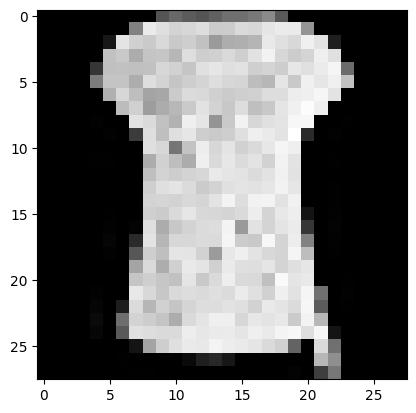

In [10]:
plt.imshow(image.numpy().squeeze(),cmap='Greys_r')

In [11]:
# 2.3)
label_names = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

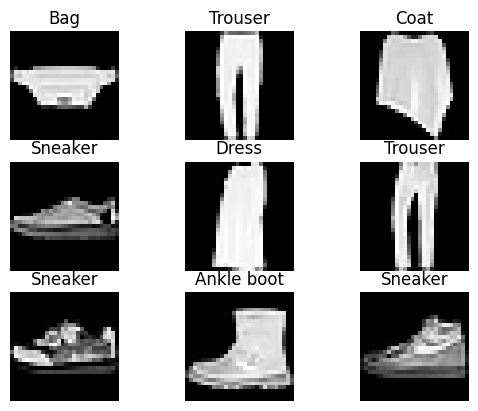

In [12]:
# 2.4)
figure = plt.figure()
cols, rows = 3,3
for i in range(1, cols*rows+1):
  j = torch.randint(len(train_set), size=(1,)).item()
  image, label = train_set[j]
  figure.add_subplot(rows, cols, i)
  plt.title(label_names[label])
  plt.axis("off")
  plt.imshow(image.numpy().squeeze(), cmap="Greys_r")
plt.show()

## Ejercicio 3)

Creando un `DataLoader` para alimentar el modelo con batchs (lotes) de entrenamiento.

**1)** Cree los `DataLoader`s para cada conjunto. Defínalos con un `batch_size` de 100 y con el flag `shuffle` seteado a `True`.

**2)** Use uno de los `DataLoader`s creados anteriormente para explorar algunos elementos del conjunto.

Notar que, el iterador devuelve el batch en un par `(image,label)`.

El objeto `images` es un tensor de dimensiones `(100,1,28,28)`.
El 100 es el tamaño del batch.
El 1 porque hay un solo canal (en este caso, un canal de escala de grises, pero podría haber varios, p. ej. uno por cada color de {Red, Green Blue} en caso que fuesen imagenes a color).
Luego, 28 y 28 porque cada imagen del dataset es de 28 x 28 píxeles.

El objeto `labels` es un tensor de dimensiones `(100,)`.
La $i$-ésima entrada `labels[i]` de `labels` es un número en $\{0,1,...,9\}$ indicando la categoría a la que pertenece la $i$-ésima imagen en el batch, guardada en `images[i]`.

In [13]:
# 3.1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = 100, shuffle = True)

## Ejercicio 4)

Defina una red neuronal de 4 capas, una de entrada, dos ocultas de $n_1=128$ y $n_2=64$ neuronas, respectivamente, y una de salida de 10 neuronas.

En las capas intermedias utilice neuronas tipo ReLU y agregueles un *dropout* de p=0.2.
En la capa de salida no utilice funciones de activación ni dropout.

Las capas sucesivas tienen que estar totalmente conectadas entre si.

In [14]:
# 4)
class Clasificadora(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 28, 28) -> (32, 14, 14)
            nn.Dropout(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # (32, 14, 14) -> (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 14, 14) -> (64, 7, 7)
        )
        
        self.classifier = nn.Sequential(
            # Capa 0
            nn.Flatten(),
            
            # Capa 1
            nn.Linear(in_features = 64*7*7, out_features = 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Capa 2
            nn.Linear(in_features = 256, out_features = 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Capa 2
            nn.Linear(in_features = 128, out_features = 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            # Capa 3
            nn.Linear(in_features = 64, out_features = 10)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

## Ejercicio 5)

Entrenamos el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` a partir del `train_set` (conjunto de entranmiento) y del `valid_set` (conjunto de validación) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando la **Cross Entropy Loss**.

**IMPORTANTE:** Notar que la **Cross Entropy Loss** aplica automáticamente una `log_softmax`.

**5)** Cree un optimizador que utilice el método de **Stochastic Gradient Descent** con un learning rate igual a $10^{-3}$.

**6)** Cree una instancia del modelo.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop de entrenamiento y validación que trabaje con el `train_loader` y el `valid_loader`, respectivamente, usando un numero arbitrario de épocas.
Este loop debe guardar en cuatro listas los valores de los promedios del **Cross Entropy Loss** y las fracciones de clasificaciones correctas o **precisión** (accuracy) sobre el conjunto de **entrenamiento** y el de **validación**, respectivamente.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso anterior para graficar en función de las épocas la **Cross Entropy Loss** de **entrenamiento** y de **validación**.
Realize un gráfico análogo pero con la **precisión**.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Repita los experimentos variando hiperparámetros. Por ejemplo:

- El learning-rate.
- El optimizador (ej. puede usar ADAM).
- El valor de dropout.
- El número de neuronas en las capas intermedias.
- El número de épocas de entrenamiento.
- El tamaño de los lotes.

Discuta los resultados.

In [15]:
# 5.1)
# Definimos la función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    num_samples = len(dataloader.dataset)
    nun_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        batch_size = len(X)
        sum_samples += batch_size
        pred = model(X)
        loss = loss_fn(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()*batch_size
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % (nun_batches/10) == 0:
            avrg_loss = sum_loss/sum_samples
            precision = sum_correct/sum_samples
            print(f"@train_loop batch={batch:>5d} avrg_loss={avrg_loss:>7f} processed samples={100*sum_samples/num_samples:>5.1f}%")
    assert num_samples == sum_samples
    avrg_loss = sum_loss/sum_samples
    precision = sum_correct/sum_samples
    return avrg_loss, precision

In [16]:
# 5.2)
# Definimos la función de validación
def eval_loop(dataloader, model, loss_fn):
    model.eval()
    num_samples = len(dataloader.dataset)
    nun_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0

    with torch.no_grad():
        for X,y in dataloader:
          X = X.to(device)
          y = y.to(device)
          batch_size = len(X)
          sum_samples += batch_size
          pred = model(X)
          loss = loss_fn(pred,y)
          sum_loss += loss.item()*batch_size
          sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    assert num_samples == sum_samples
    avrg_loss = sum_loss/sum_samples
    precision = sum_correct/sum_samples
    print(f"@eval_loop avg_loss={avrg_loss:>8f} precision={100*precision:>0.1f}%")
    return avrg_loss, precision

In [17]:
# 5.3)
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
print(f'num_train_batches={num_train_batches}')
print(f'num_valid_batches={num_valid_batches}')

num_train_batches=600
num_valid_batches=100


In [18]:
# 5.4)
loss_fn = nn.CrossEntropyLoss()

In [19]:
# 5.5)
# Ejemplo: pasar encoder a tu modelo Clasificadora con dropout fijo en la clasificadora
# p_dropout_clf = 0.2
# clasificador = Clasificadora(p=p_dropout_clf, n1=128, n2=64, encoder=autoencoder.encoder)

In [20]:
# 5.6)
# learning_rate = 1e-4
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(clasificador.classifier.parameters(), lr=learning_rate, eps=1e-08, weight_decay= 0, amsgrad= False)

In [21]:
# 5.7)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#clasificador = clasificador.to(device)

In [22]:
# 5.8) y 5.9)
import torch
import json
import os

# Crear carpeta de resultados si no existe
os.makedirs("resultados", exist_ok=True)

# Inicializar el modelo Clasificadora con el encoder del Autoencoder preentrenado
p_dropout_clf = 0.2
learning_rate = 1e-3
model = Clasificadora()
model = model.to(device)

# 2) IMPORTANTE: Permitir que el encoder también se entrene (fine-tuning completo)
# Por defecto, todos los parámetros están habilitados para entrenamiento
# Si quisieras congelar el encoder, harías: 
# for param in model.encoder.parameters():
#     param.requires_grad = False

# 3) Configurar optimizador para TODOS los parámetros (encoder + clasificador)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0, amsgrad=False)

num_epochs = 60

list_avg_train_loss_incorrecta = []
list_avg_train_loss = []
list_avg_valid_loss = []
list_train_precision_incorrecta = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n-------------------------------')

    train_avg_loss_incorrecta, train_precision_incorrecta = train_loop(
        train_loader, model, loss_fn, optimizer
    )

    train_avg_loss, train_precision = eval_loop(
        train_loader, model, loss_fn
    )

    valid_avg_loss, valid_precision = eval_loop(
        valid_loader, model, loss_fn
    )

    list_avg_train_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_avg_train_loss.append(train_avg_loss)
    list_avg_valid_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

    print(f"📊 Epoch {epoch+1} Summary:")
    print(f"   Train Loss: {train_avg_loss:.4f} | Train Acc: {train_precision:.4f}")
    print(f"   Valid Loss: {valid_avg_loss:.4f} | Valid Acc: {valid_precision:.4f}\n")

print(" FINALIZADO!\n")

# ===============================================================
#          🔥 GUARDAR MODELO Y MÉTRICAS (FORMATO EXPERIMENTOS)
# ===============================================================

# 1) Guardar modelo (solo pesos)
model_path = "resultados/modelo.pt"
torch.save(model.state_dict(), model_path)

# 1b) Guardar checkpoint completo (pesos + optimizador + config)
checkpoint_path = "resultados/checkpoint.pt"
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "config": {
        "num_epochs": num_epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "p_dropout_clf": p_dropout_clf
    }
}, checkpoint_path)

# 2) Guardar métricas
metrics_path = "resultados/metricas.pt"
torch.save({
    "train_loss_incorrecta": list_avg_train_loss_incorrecta,
    "train_loss": list_avg_train_loss,
    "valid_loss": list_avg_valid_loss,
    "train_precision_incorrecta": list_train_precision_incorrecta,
    "train_precision": list_train_precision,
    "valid_precision": list_valid_precision,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "p_dropout_clf": p_dropout_clf
}, metrics_path)

# 3) Guardar JSON con resumen
resumen = {
    "final_train_precision": list_train_precision[-1],
    "final_valid_precision": list_valid_precision[-1],
    "final_valid_loss": list_avg_valid_loss[-1],
    "model_path": model_path,
    "checkpoint_path": checkpoint_path,
    "metrics_path": metrics_path
}

json_path = "resultados/resumen.json"
with open(json_path, "w") as f:
    json.dump(resumen, f, indent=4)

print("✔ Modelo guardado en:", model_path)
print("✔ Checkpoint guardado en:", checkpoint_path)
print("✔ Métricas guardadas en:", metrics_path)
print("✔ Resumen guardado en:", json_path)



Epoch 1
-------------------------------
@train_loop batch=    0 avrg_loss=2.302632 processed samples=  0.2%
@train_loop batch=   60 avrg_loss=1.601646 processed samples= 10.2%
@train_loop batch=  120 avrg_loss=1.275837 processed samples= 20.2%
@train_loop batch=  180 avrg_loss=1.105527 processed samples= 30.2%
@train_loop batch=  240 avrg_loss=1.009429 processed samples= 40.2%
@train_loop batch=  300 avrg_loss=0.946644 processed samples= 50.2%
@train_loop batch=  360 avrg_loss=0.895523 processed samples= 60.2%
@train_loop batch=  420 avrg_loss=0.861054 processed samples= 70.2%
@train_loop batch=  480 avrg_loss=0.827820 processed samples= 80.2%
@train_loop batch=  540 avrg_loss=0.802310 processed samples= 90.2%
@eval_loop avg_loss=0.515540 precision=81.2%
@eval_loop avg_loss=0.536863 precision=80.2%
📊 Epoch 1 Summary:
   Train Loss: 0.5155 | Train Acc: 0.8121
   Valid Loss: 0.5369 | Valid Acc: 0.8015

Epoch 2
-------------------------------
@train_loop batch=    0 avrg_loss=0.426315 pro

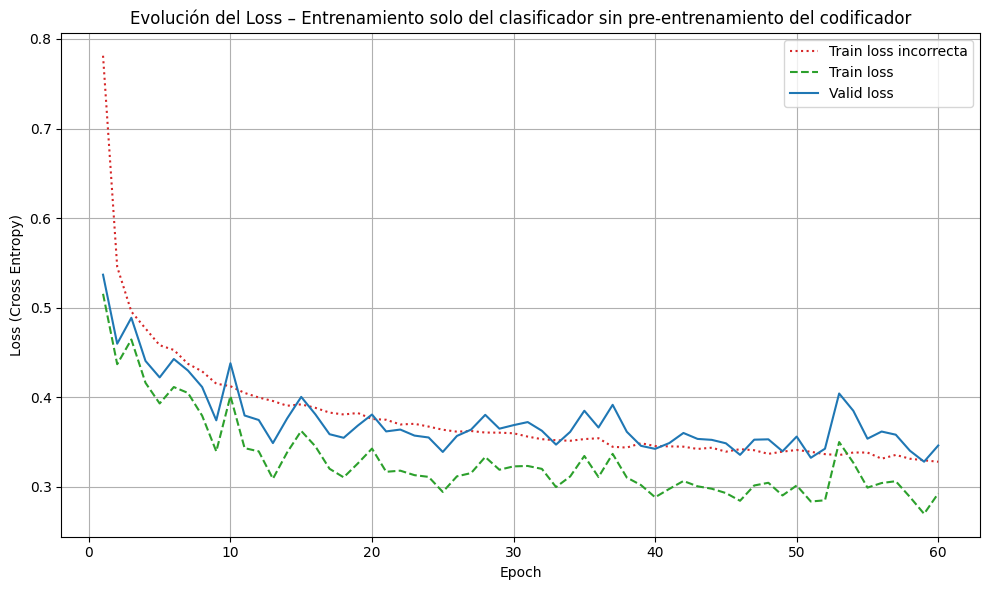

✔ Gráfico guardado en resultados/loss.png


In [23]:
import torch
import matplotlib.pyplot as plt
import os

# ---------------------------------------------------------
#    ARCHIVOS DE MÉTRICAS GUARDADOS DE CADA EXPERIMENTO
# ---------------------------------------------------------
os.makedirs("resultados", exist_ok=True)
plt.figure(figsize=(10, 6))

# Colores y estilos (coherentes con el gráfico comparativo)
plt.plot(
    range(1, len(list_avg_train_loss_incorrecta) + 1),
    list_avg_train_loss_incorrecta,
    linestyle=":",
    color="tab:red",
    label="Train loss incorrecta"
)

plt.plot(
    range(1, len(list_avg_train_loss) + 1),
    list_avg_train_loss,
    linestyle="--",
    color="tab:green",
    label="Train loss"
)

plt.plot(
    range(1, len(list_avg_valid_loss) + 1),
    list_avg_valid_loss,
    linestyle="-",
    color="tab:blue",
    label="Valid loss"
)

plt.title("Evolución del Loss – Entrenamiento solo del clasificador sin pre-entrenamiento del codificador")
plt.xlabel("Epoch")
plt.ylabel("Loss (Cross Entropy)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guardar el gráfico
plt.savefig("resultados/loss.png", dpi=300)
plt.show()

print("✔ Gráfico guardado en resultados/loss.png")


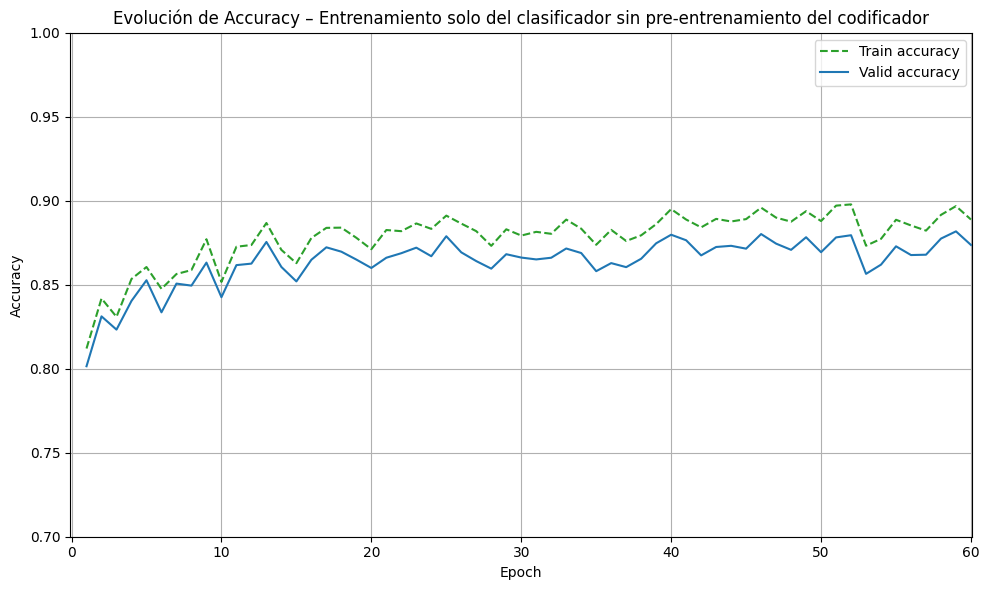

✔ Gráfico de accuracy guardado en: resultados/accuracy_from_file.png


In [3]:
import torch
import matplotlib.pyplot as plt
import os

# ---------------------------------------------------------
#    CARGAR MÉTRICAS GUARDADAS DEL EXPERIMENTO
# ---------------------------------------------------------
metrics_path = "resultados/metricas.pt"
metrics = torch.load(metrics_path, map_location="cpu")

list_train_precision = metrics["train_precision"]
list_valid_precision = metrics["valid_precision"]
# Si quisieras usar la "incorrecta", también está:
# list_train_precision_incorrecta = metrics["train_precision_incorrecta"]

os.makedirs("resultados", exist_ok=True)
plt.figure(figsize=(10, 6))

# Línea objetivo
#plt.axhline(y=0.9, color="grey", linestyle="--")

# Colores tabulados (consistentes)
plt.plot(
    range(1, len(list_train_precision) + 1),
    list_train_precision,
    linestyle="--",
    color="tab:green",
    label="Train accuracy"
)

plt.plot(
    range(1, len(list_valid_precision) + 1),
    list_valid_precision,
    linestyle="-",
    color="tab:blue",
    label="Valid accuracy"
)

plt.title("Evolución de Accuracy – Entrenamiento solo del clasificador sin pre-entrenamiento del codificador")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(-0.1, len(list_valid_precision) + 0.1)
plt.ylim(0.7, 1.0)

plt.legend()
plt.grid(True)
plt.tight_layout()

save_path = "resultados/accuracy_from_file.png"
plt.savefig(save_path, dpi=300)
plt.show()

print("✔ Gráfico de accuracy guardado en:", save_path)

✔ Modelo cargado desde: resultados/modelo.pt


<Figure size 600x600 with 0 Axes>

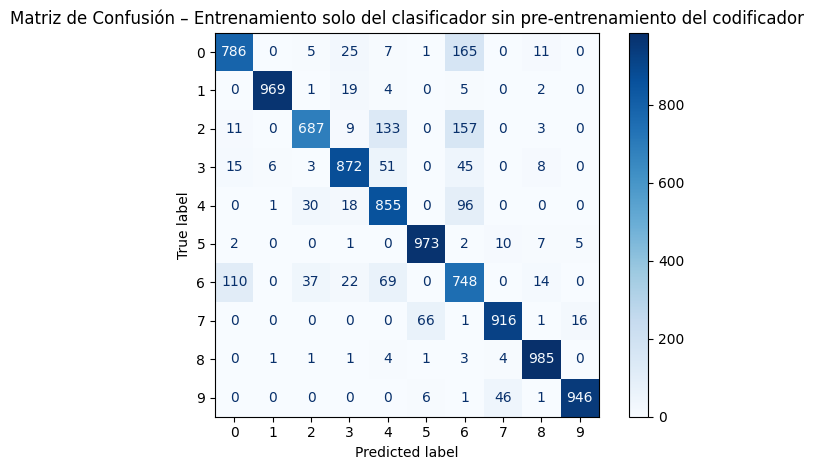

✔ Matriz de confusión guardada en: resultados/matriz_confusion_5_11.png


In [25]:
import torch
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------
#   1) Cargar el modelo entrenado
# ---------------------------------------------------------
model_path = "resultados/modelo.pt"

clasificador = model.to(device)
clasificador.load_state_dict(torch.load(model_path, map_location=device))
clasificador.eval()

print("✔ Modelo cargado desde:", model_path)

# ---------------------------------------------------------
#   2) Obtener predicciones sobre conjunto VALID
# ---------------------------------------------------------
y_true = []
y_pred = []

with torch.no_grad():
    for x, labels in valid_loader:
        x, labels = x.to(device), labels.to(device)

        outputs = clasificador(x)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ---------------------------------------------------------
#   3) Matriz de confusión
# ---------------------------------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

plt.title("Matriz de Confusión – Entrenamiento solo del clasificador sin pre-entrenamiento del codificador")
plt.tight_layout()

out_png = "resultados/matriz_confusion_5_11.png"
plt.savefig(out_png, dpi=300)
plt.show()

print("✔ Matriz de confusión guardada en:", out_png)
